# Collaborative Filtering

In [196]:
# Packages
%pip install pandas
%pip install surprise
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [197]:
# Imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from surprise import Reader, Dataset, SVD, NMF
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy
from pathlib import Path

### Read Data

In [ ]:
game_data_path = Path("../data/final_game_data/")
game_data_files = list(game_data_path.glob("*.csv"))
game_data = pd.read_csv(game_data_files[0])
print(game_data.shape)

(2632, 98)


In [ ]:
OU_data_path = Path("../data/odds_data_processed/")
OU_data_files = list(OU_data_path.glob("*.csv"))
OU_data = pd.read_csv(OU_data_files[0])
print(OU_data.shape)

(1288, 14)


#### Standardize names!

In [200]:
game_data_names = {'Golden State Warriors':'GSW',
                'Los Angeles Lakers': 'LAL',
                'San Antonio Spurs': 'SAS',
                'Cleveland Cavaliers': 'CLE',
                'Denver Nuggets': 'DEN',
                'Indiana Pacers': 'IND',
                'Memphis Grizzlies': 'MEM',
                'New Jersey Nets': 'BRK',
                'Brooklyn Nets': 'BRK',
                'New Orleans Hornets': 'NOP',
                'New Orleans Pelicans': 'NOP',
                'Orlando Magic': 'ORL',
                'Toronto Raptors': 'TOR',
                'Miami Heat': 'MIA',
                'Seattle SuperSonics': 'SEA',
                'Utah Jazz': 'UTA',
                'Atlanta Hawks': 'ATL',
                'Boston Celtics': 'BOS',
                'Charlotte Bobcats': 'CHA',
                'Charlotte Hornets': 'CHA',
                'Chicago Bulls': 'CHI',
                'Los Angeles Clippers': 'LAC',
                'Minnesota Timberwolves': 'MIN',
                'Phoenix Suns': 'PHO',
                'Dallas Mavericks': 'DAL',
                'Houston Rockets': 'HOU',
                'Milwaukee Bucks': 'MIL',
                'Philadelphia 76ers': 'PHI',
                'Washington Wizards': 'WAS',
                'Detroit Pistons': 'DET',
                'New York Knicks': 'NYK',
                'Sacramento Kings': 'SAC',
                'Portland Trail Blazers': 'POR',
                'Oklahoma City Thunder': 'OKC'
        }
OU_data_names = {}
for name in list(pd.unique(OU_data.Home)):
    found = False
    for s_name in game_data_names:
        if name in s_name:
            found = True
            OU_data_names[name] = game_data_names[s_name]
    if not found: print(name)
OU_data_names["LA Lakers"] = "LAL"
OU_data_names["LA Clippers"] = "LAC"
OU_data_names["Okla City"] = "OKC"

LA Lakers
LA Clippers


In [201]:
def standardize_team_names(dataframe, mapping_dict, team_columns):
    df_copy = dataframe.copy()
    for column in team_columns:
        df_copy[column] = df_copy[column].map(mapping_dict)
    return df_copy

OU_data = standardize_team_names(OU_data, OU_data_names, ['Home', 'Away'])
game_data = standardize_team_names(game_data, game_data_names, ['team', 'opponent'])

#### Merging the two datatables (OU and game data)

In [202]:
# Helper function to create a standard 'Index'
def make_index(row, col1, col2, col3):
    return str(row[col1]) + str(row[col2]) + str(row[col3])

# Format 'Date' and create 'Index'
game_data["date"] = game_data["date"].apply(lambda x: str(x)[:-1])
game_data["date"] = pd.to_datetime(game_data["date"], format="%Y%m%d").dt.strftime("%Y%m%d")
game_data["Index"] = game_data.apply(lambda x: make_index(x, "date", "team", "opponent"), axis=1)
print(game_data["Index"])

# Format 'Date' and create 'Index'
OU_data["Date"] = pd.to_datetime(OU_data["Date"], format="%Y-%m-%d").dt.strftime("%Y%m%d")
OU_data["Index"] = OU_data.apply(lambda x: make_index(x, "Date", "Home", "Away"), axis=1)
print(OU_data["Index"])

# Merge
combined = pd.merge(OU_data, game_data, on='Index')
# Use 'Index' column as actual index
combined = combined.drop(["Unnamed: 0_x", "Unnamed: 0_y", "date", "Home", "Away", "index"], axis=1)
combined = combined.set_index("Index")
combined = combined.sort_index()
print("Shape: {combined.shape}")
combined.head(5)



0       20071030GSWUTA
1       20071030UTAGSW
2       20071030LALHOU
3       20071030HOULAL
4       20071030SASPOR
             ...      
2627    20080612BOSLAL
2628    20080615LALBOS
2629    20080615BOSLAL
2630    20080617BOSLAL
2631    20080617LALBOS
Name: Index, Length: 2632, dtype: object
0       20071030SASPOR
1       20071030GSWUTA
2       20071030LALHOU
3       20071031TORPHI
4       20071031INDWAS
             ...      
1283    20080608BOSLAL
1284    20080610LALBOS
1285    20080612LALBOS
1286    20080615LALBOS
1287    20080617BOSLAL
Name: Index, Length: 1288, dtype: object
Shape: {combined.shape}


,Date,OU,Spread,OU_2H,Spread_2H,ML_home,ML_away,Points,Win Margin,2H Points,...,opponent_HOB,opponent_STL,opponent_TRB,opponent_FTA,opponent_BLK,opponent_FTr,opponent_TS%,opponent_FT/FGA,opponent_3P%,home
Index,,,,,,,,,,,,,,,,,,,,,
20071030GSWUTA,20071030,214.5,3.0,105.5,3.0,-120,100,213,-21,100,...,1.585366,9.0,56.0,36.0,7.0,0.400,0.552721,0.333333,0.454545,1
20071030LALHOU,20071030,191.0,2.5,99,3,190,-230,188,-2,102,...,1.676471,10.0,49.0,31.0,5.0,0.419,0.541990,0.283784,0.272727,1
20071030SASPOR,20071030,184.0,12.5,95,5,-1400,900,203,9,95,...,1.384615,1.0,40.0,17.0,4.0,0.218,0.567384,0.166667,0.461538,1
20071031BRKCHI,20071031,188.0,2.0,94,3,-125,105,215,9,95,...,1.605263,7.0,45.0,26.0,3.0,0.271,0.479337,0.197917,0.347826,1
20071031CLEDAL,20071031,186.0,3.0,91.5,4.0,120,-140,166,-18,78,...,1.696970,6.0,36.0,20.0,8.0,0.290,0.591260,0.246377,0.500000,1


## Collaborative filtering code

### Config

In [203]:
unique_dates = pd.unique(combined.Date)

# Data window ranges
window_size = 7
max_window_range = 21

# Model settings
num_factors = 10
epochs = 1000

# Prediction score range
min_score = 75
max_score = 280

In [204]:
def train_model(train):
    
    model = SVD(n_factors=num_factors, n_epochs = epochs)
    
    ratings_dict = {'team': list(train.team),
                    'opponent': list(train.opponent),
                    'score': list(train.Points)}
    df = pd.DataFrame(ratings_dict)

    reader = Reader(rating_scale=(min_score, max_score)) # Range of values to predict
    data = Dataset.load_from_df(df[['team', 'opponent', 'score']], reader)
    
    train = data.build_full_trainset()
    model.fit(train)
    
    return model
    

In [205]:
def test_model(test, model, verbose=False): 
    # Prediction results:
    mse = 0
    errors = 0
    num_bets = 0

    for _, game in test.iterrows():
        # Generate prediction
        predicted_score = model.predict(
            uid=game.team,
            iid=game.opponent,
            r_ui=game.Points
        ).est
        
        actual_score = game.Points
        mse += (actual_score - predicted_score) ** 2
        
        if np.abs(predicted_score - game.OU) > 4:
            num_bets += 1
            if (predicted_score - game.OU)*(actual_score - game.OU) < 0: 
                errors += 1
        
    if verbose: 
        avg_mse = mse/len(test.team)
        print(f"Average MSE: {avg_mse}")
        
    return mse, len(test.team), errors, num_bets

In [ ]:
mses = []
errors = []
t_mses = []
t_errors = []
look_back_range = list(range(1, max_window_range))

for window_size in look_back_range:
    test_mse = 0
    test_count = 0
    test_err = 0
    test_bets = 0
    train_mse = 0
    train_count = 0
    train_err = 0
    train_bets = 0
    
    for i, date in enumerate(unique_dates):
        if i < window_size: continue

        window = unique_dates[i - window_size:i]
        window_data = combined.loc[combined['Date'].isin(window)]
        test_window = combined.loc[combined['Date'].isin(unique_dates[i:i + 1])]

        # Train
        model = train_model(window_data)
        # Test metrics
        se, n_tests, n_errors, n_bets = test_model(test_window, model)
        test_mse += se
        test_count += n_tests
        test_err += n_errors
        test_bets += n_bets
        
        # Training metrics
        t_se, t_n_tests, t_n_errors, t_n_bets = test_model(window_data, model)
        train_mse += t_se
        train_count += t_n_tests
        train_err += t_n_errors
        train_bets += t_n_bets
        
    mses.append(test_mse/test_count)
    errors.append(test_err/test_bets)
    t_mses.append(train_mse/train_count)
    t_errors.append(train_err/train_bets)
    
    print("-----")
    print(f"Window: Last {window_size} days")
    print(f"Test MSE: {test_mse/test_count:.4f} ({test_count} tests)")
    print(f"Train MSE: {train_mse/train_count:.4f} ({train_count} tests)")

-----
Window: Last 1 days
Test MSE: 546.5196 (1282 tests)
Train MSE: 0.2933 (1284 tests)
-----
Window: Last 2 days
Test MSE: 477.7985 (1274 tests)
Train MSE: 0.5171 (2564 tests)
-----
Window: Last 3 days
Test MSE: 471.0487 (1271 tests)
Train MSE: 1.3876 (3835 tests)
-----
Window: Last 4 days
Test MSE: 457.6050 (1258 tests)
Train MSE: 2.2168 (5102 tests)
-----
Window: Last 5 days
Test MSE: 461.4486 (1251 tests)
Train MSE: 2.8520 (6355 tests)
-----
Window: Last 6 days
Test MSE: 474.7760 (1243 tests)
Train MSE: 3.2901 (7600 tests)
-----
Window: Last 7 days
Test MSE: 463.8068 (1242 tests)
Train MSE: 3.8257 (8836 tests)
-----
Window: Last 8 days
Test MSE: 468.8711 (1234 tests)
Train MSE: 4.3708 (10070 tests)
-----
Window: Last 9 days
Test MSE: 485.5181 (1225 tests)
Train MSE: 5.0330 (11295 tests)
-----
Window: Last 10 days
Test MSE: 490.8790 (1222 tests)
Train MSE: 5.6180 (12510 tests)
-----
Window: Last 11 days
Test MSE: 495.9544 (1209 tests)
Train MSE: 6.1192 (13721 tests)
-----
Window: L

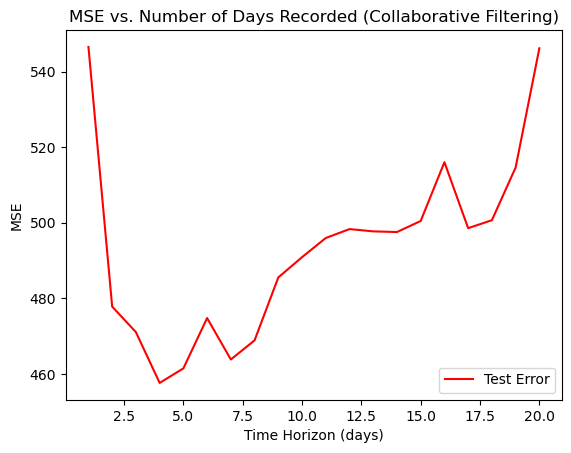

In [207]:
plt.plot(look_back_range, mses, color="red", label="Test Error")
#plt.plot(choices, t_mses, color="blue", label="Train Error")
plt.legend()
plt.xlabel("Time Horizon (days)")
plt.ylabel("MSE")
plt.title("MSE vs. Number of Days Recorded (Collaborative Filtering)")
plt.savefig("collab_filtering.jpg")
plt.show()

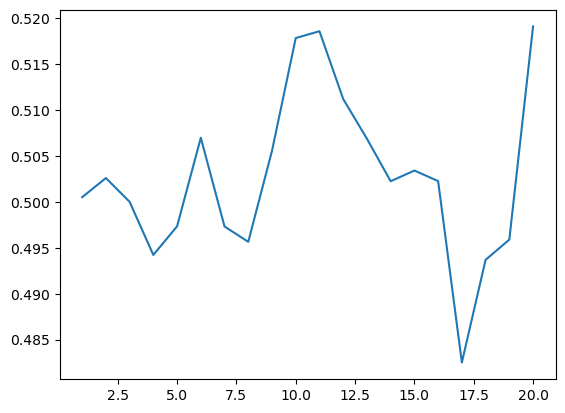

In [208]:
plt.plot(look_back_range, errors)